# Parameter Tuning
This notebook is for parameter tuning only. Other results are presented in the main notebook.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
pd.set_option('display.max_columns', None)

In [14]:
data = pd.read_csv("new_theorem_data.csv", index_col="ListingID")[0:20000]

In [16]:
del_col = ["ListingNumber", "StrBorrowerCity", "NumOpenTradesDelinqOrPastDue6"]
for col in data.columns:
    if data[col].isnull().sum() > len(data)/2:
        del_col.append(col)
        
data.drop(del_col, axis=1, inplace=True)

In [17]:
date_col = ['DateCreditPulled', 'DateFirstCredit',
       'DateListingCreation', 'DateListingStart', 'DateWholeLoanStart']
data[date_col] = data[date_col].fillna("2014-01-26 18:28:00")
data[date_col] = data[date_col].astype("datetime64[ns]")

for col in date_col:
    data[col] = (data[col] - data[col].min()) / np.timedelta64(1, 'D')

In [18]:
for col in data.columns:
    if data[col].dtype == "bool":
        data[col] = data[col].astype("int64")

In [19]:
cat_col = ["EnumListingStatus", "CreditGrade", "EnumListingCategory", "StrEmploymentStatus", "StrOccupation", "StrState", "EnumLoanFractionalType"]
num_col = []
for col in data.columns:
    if col not in cat_col:
        num_col.append(col)

data[cat_col] = data[cat_col].fillna("Other")

for col in cat_col:
    data[col] = data[col].astype("category")
    
data["EnumListingStatus"].cat.categories = [1,0]

In [20]:
def split_data(data, valid_ratio, test_ratio, y_column="EnumListingStatus"):
    N = len(data)
    idx = np.random.permutation(N)
    test_cut, valid_cut = int(N * test_ratio), int(N * (valid_ratio + test_ratio))
    train, valid, test = data.iloc[idx[valid_cut:]], data.iloc[idx[test_cut : valid_cut]], data.iloc[idx[:test_cut]]
    return train.drop(y_column, axis=1).copy(), pd.DataFrame(train[y_column]).copy(), valid.drop(y_column, axis=1).copy(), pd.DataFrame(valid[y_column]).copy(), test.drop(y_column, axis=1).copy(), pd.DataFrame(test[y_column]).copy()

train_x, train_y, valid_x, valid_y, test_x, test_y = split_data(data, 0.3, 0)

In [21]:
cat_col.remove("EnumListingStatus")

int_col, float_col = [], []
for col in data.columns:
    if data[col].dtype == "float64":
        float_col.append(col)
    if data[col].dtype == "int64":
        int_col.append(col)

del(data)

In [22]:
class Preprocessor():
    def __init__(self, num_col, cat_col):
        self.mean, self.std, self.median = dict(), dict(), dict()
        self.num_col, self.cat_col = num_col, cat_col
    def fit(self, X):
        self.mean, self.std, self.median = dict(X[self.num_col].mean()), dict(X[self.num_col].std()), dict(X[self.num_col].median())
        return self
    def transform(self, X):
        for col in self.num_col:
            X[col].fillna(self.median[col], inplace=True)
            #X[col] = (X[col] - self.mean[col]) / self.std[col]
        return pd.get_dummies(X)

In [23]:
preprocessor = Preprocessor(num_col, cat_col)
preprocessor.fit(train_x)
train_x, valid_x, test_x = preprocessor.transform(train_x), preprocessor.transform(valid_x), preprocessor.transform(test_x)

In [25]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(np.array(train_x), np.array(train_y).reshape(-1))
print("in sample acc = ", model_lr.score(np.array(train_x), np.array(train_y).reshape(-1))) 
print("out of sample acc = ", model_lr.score(np.array(valid_x), np.array(valid_y).reshape(-1)))

in sample acc =  0.633285714286
out of sample acc =  0.626833333333


In [26]:
from sklearn.naive_bayes import BernoulliNB
model_nb = BernoulliNB()
model_nb.fit(np.array(train_x), np.array(train_y).reshape(-1))
print("in sample acc = ", model_nb.score(np.array(train_x), np.array(train_y).reshape(-1))) 
print("out of sample acc = ", model_nb.score(np.array(valid_x), np.array(valid_y).reshape(-1)))

in sample acc =  0.643928571429
out of sample acc =  0.624166666667


In [145]:
from sklearn.gaussian_process import GaussianProcessClassifier
model_gp = GaussianProcessClassifier()
model_gp.fit(np.array(train_x), np.array(train_y).reshape(-1))
print("in sample acc = ", model_gp.score(np.array(train_x), np.array(train_y).reshape(-1))) 
print("out of sample acc = ", model_gp.score(np.array(valid_x), np.array(valid_y).reshape(-1)))

in sample acc =  1.0
out of sample acc =  0.373666666667


In [28]:
from sklearn.tree import DecisionTreeClassifier
model_tree = DecisionTreeClassifier(criterion="entropy", max_features=100, max_depth=30)
model_tree.fit(np.array(train_x), np.array(train_y).reshape(-1))
print("in sample acc = ", model_tree.score(np.array(train_x), np.array(train_y).reshape(-1))) 
print("out of sample acc = ", model_tree.score(np.array(valid_x), np.array(valid_y).reshape(-1)))

in sample acc =  0.963214285714
out of sample acc =  0.587333333333


In [29]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(np.array(train_x), np.array(train_y).reshape(-1))
print("in sample acc = ", model_rf.score(np.array(train_x), np.array(train_y).reshape(-1))) 
print("out of sample acc = ", model_rf.score(np.array(valid_x), np.array(valid_y).reshape(-1)))

in sample acc =  0.987714285714
out of sample acc =  0.594333333333


In [30]:
from sklearn.ensemble import GradientBoostingClassifier
model_gbdt = GradientBoostingClassifier()
model_gbdt.fit(np.array(train_x), np.array(train_y).reshape(-1))
print("in sample acc = ", model_gbdt.score(np.array(train_x), np.array(train_y).reshape(-1))) 
print("out of sample acc = ", model_gbdt.score(np.array(valid_x), np.array(valid_y).reshape(-1)))

in sample acc =  0.698642857143
out of sample acc =  0.661333333333


In [31]:
from sklearn.ensemble import AdaBoostClassifier
model_ada = AdaBoostClassifier()
model_ada.fit(np.array(train_x), np.array(train_y).reshape(-1))
print("in sample acc = ", model_ada.score(np.array(train_x), np.array(train_y).reshape(-1))) 
print("out of sample acc = ", model_ada.score(np.array(valid_x), np.array(valid_y).reshape(-1)))

in sample acc =  0.673714285714
out of sample acc =  0.657833333333


In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("FPR")
    plt.ylabel("TPR")

# Random Forest:
n_estimators = 1000

max_features = sqrt

max_depth = 10

In [69]:
from sklearn.ensemble import RandomForestClassifier
n_estimators_list = [10,30,50,100,300,1000,3000]
auc1, auc2 = [], []
for n_estimators in n_estimators_list:
    model_rf = RandomForestClassifier(n_estimators=n_estimators,n_jobs=6, max_features="sqrt")
    model_rf.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc1.append(roc_auc_score(np.array(valid_y).reshape(-1), model_rf.predict_proba(np.array(valid_x))[:,1]))
    
    model_rf = RandomForestClassifier(n_estimators=n_estimators,n_jobs=6, max_features="log2")
    model_rf.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc2.append(roc_auc_score(np.array(valid_y).reshape(-1), model_rf.predict_proba(np.array(valid_x))[:,1]))

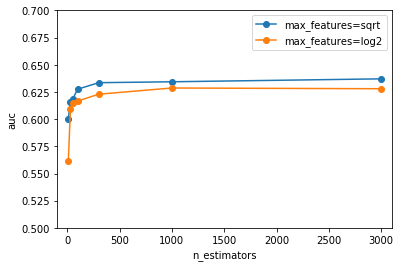

In [70]:
plt.plot(n_estimators_list, auc1, "o-", label="max_features=sqrt")
plt.plot(n_estimators_list, auc2, "o-", label="max_features=log2")
plt.axis([-100,3100,0.5,0.7])
plt.xlabel("n_estimators")
plt.ylabel("auc")
plt.legend()
plt.show()

In [86]:
from sklearn.ensemble import RandomForestClassifier
max_depth_list = [1,4,8,10,12,16,32]
auc1, auc2 = [], []
for max_depth in max_depth_list:
    model_rf = RandomForestClassifier(n_estimators=30,n_jobs=6, max_depth=max_depth)
    model_rf.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc1.append(roc_auc_score(np.array(valid_y).reshape(-1), model_rf.predict_proba(np.array(valid_x))[:,1]))
    
    model_rf = RandomForestClassifier(n_estimators=300,n_jobs=6, max_depth=max_depth)
    model_rf.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc2.append(roc_auc_score(np.array(valid_y).reshape(-1), model_rf.predict_proba(np.array(valid_x))[:,1]))

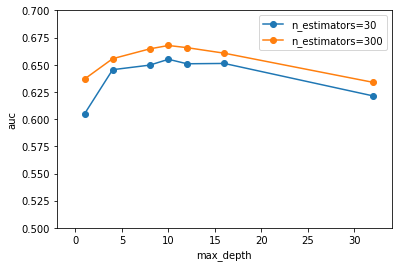

In [87]:
plt.plot(max_depth_list, auc1, "o-", label="n_estimators=30")
plt.plot(max_depth_list, auc2, "o-", label="n_estimators=300")
plt.axis([-2,34,0.5,0.7])
plt.xlabel("max_depth")
plt.ylabel("auc")
plt.legend()
plt.show()

# Decision Tree
max_depth = 8

max_features = none

In [104]:
from sklearn.tree import DecisionTreeClassifier
max_depth_list = [1,4,8,10,12,16,32]
auc1, auc2 = [], []
for max_depth in max_depth_list:
    model = DecisionTreeClassifier(max_depth=max_depth, max_features="sqrt")
    model.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc1.append(roc_auc_score(np.array(valid_y).reshape(-1), model.predict_proba(np.array(valid_x))[:,1]))
    
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc2.append(roc_auc_score(np.array(valid_y).reshape(-1), model.predict_proba(np.array(valid_x))[:,1]))

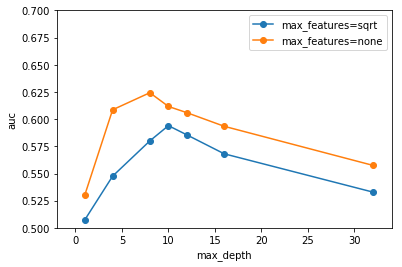

In [105]:
plt.plot(max_depth_list, auc1, "o-", label="max_features=sqrt")
plt.plot(max_depth_list, auc2, "o-", label="max_features=none")
plt.axis([-2,34,0.5,0.7])
plt.xlabel("max_depth")
plt.ylabel("auc")
plt.legend()
plt.show()

# Gradient Boosted
n_estimator = 300

max_features = sqrt

max_depth = 4

learning_rate = 0.07

In [100]:
from sklearn.ensemble import GradientBoostingClassifier
n_estimators_list = [10,30,50,100,300,1000]
auc1, auc2 = [], []
for n_estimators in n_estimators_list:
    model = GradientBoostingClassifier(n_estimators=n_estimators, max_features="sqrt")
    model.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc1.append(roc_auc_score(np.array(valid_y).reshape(-1), model.predict_proba(np.array(valid_x))[:,1]))
    
    model = GradientBoostingClassifier(n_estimators=n_estimators)
    model.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc2.append(roc_auc_score(np.array(valid_y).reshape(-1), model.predict_proba(np.array(valid_x))[:,1]))

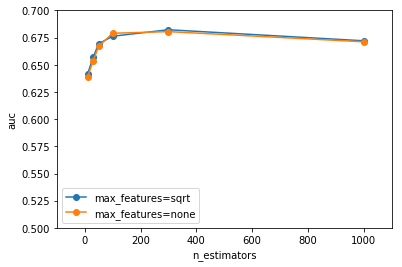

In [103]:
plt.plot(n_estimators_list, auc1, "o-", label="max_features=sqrt")
plt.plot(n_estimators_list, auc2, "o-", label="max_features=none")
plt.axis([-100,1100,0.5,0.7])
plt.xlabel("n_estimators")
plt.ylabel("auc")
plt.legend()
plt.show()

In [117]:
from sklearn.ensemble import GradientBoostingClassifier
max_depth_list = [1,2,3,4,6,8,12]
auc1, auc2 = [], []
for max_depth in max_depth_list:
    model = GradientBoostingClassifier(max_depth=max_depth, n_estimators=300, max_features="sqrt")
    model.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc1.append(roc_auc_score(np.array(valid_y).reshape(-1), model.predict_proba(np.array(valid_x))[:,1]))
    
    model = GradientBoostingClassifier(max_depth=max_depth, n_estimators=100, max_features="sqrt")
    model.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc2.append(roc_auc_score(np.array(valid_y).reshape(-1), model.predict_proba(np.array(valid_x))[:,1]))

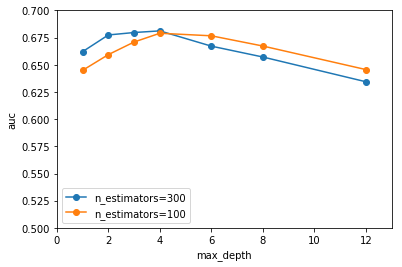

In [118]:
plt.plot(max_depth_list, auc1, "o-", label="n_estimators=300")
plt.plot(max_depth_list, auc2, "o-", label="n_estimators=100")
plt.axis([0,13,0.5,0.7])
plt.xlabel("max_depth")
plt.ylabel("auc")
plt.legend()
plt.show()

In [130]:
from sklearn.ensemble import GradientBoostingClassifier
learning_rate_list = [0.01, 0.03, 0.06, 0.07, 0.08, 0.1, 0.2, 0.3]
auc1, auc2 = [], []
for learning_rate in learning_rate_list:
    model = GradientBoostingClassifier(max_depth=4, n_estimators=300, max_features="sqrt", learning_rate=learning_rate)
    model.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc1.append(roc_auc_score(np.array(valid_y).reshape(-1), model.predict_proba(np.array(valid_x))[:,1]))
    
    model = GradientBoostingClassifier(max_depth=2, n_estimators=300, max_features="sqrt", learning_rate=learning_rate)
    model.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc2.append(roc_auc_score(np.array(valid_y).reshape(-1), model.predict_proba(np.array(valid_x))[:,1]))

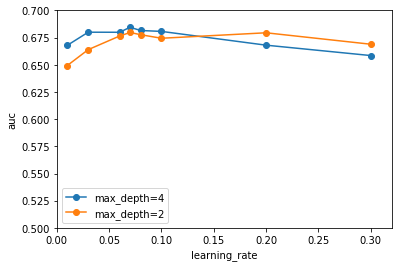

In [134]:
plt.plot(learning_rate_list, auc1, "o-", label="max_depth=4")
plt.plot(learning_rate_list, auc2, "o-", label="max_depth=2")
plt.axis([0,0.32,0.5,0.7])
plt.xlabel("learning_rate")
plt.ylabel("auc")
plt.legend()
plt.show()

# AdaBoost
n_estimator = 300

learning_rate = 0.3

In [135]:
from sklearn.ensemble import AdaBoostClassifier
n_estimators_list = [10,30,50,100,300,1000]
auc1, auc2 = [], []
for n_estimators in n_estimators_list:
    model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=1)
    model.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc1.append(roc_auc_score(np.array(valid_y).reshape(-1), model.predict_proba(np.array(valid_x))[:,1]))
    
    model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=0.5)
    model.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc2.append(roc_auc_score(np.array(valid_y).reshape(-1), model.predict_proba(np.array(valid_x))[:,1]))

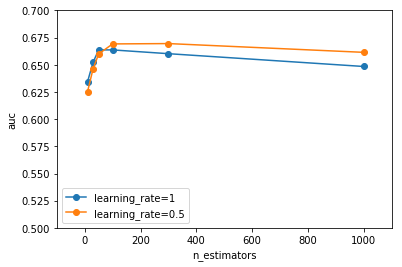

In [136]:
plt.plot(n_estimators_list, auc1, "o-", label="learning_rate=1")
plt.plot(n_estimators_list, auc2, "o-", label="learning_rate=0.5")
plt.axis([-100,1100,0.5,0.7])
plt.xlabel("n_estimators")
plt.ylabel("auc")
plt.legend()
plt.show()

In [138]:
from sklearn.ensemble import GradientBoostingClassifier
learning_rate_list = [0.1, 0.3, 0.5, 0.7, 0.9]
auc1, auc2 = [], []
for learning_rate in learning_rate_list:
    model = AdaBoostClassifier(n_estimators=100, learning_rate=learning_rate)
    model.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc1.append(roc_auc_score(np.array(valid_y).reshape(-1), model.predict_proba(np.array(valid_x))[:,1]))
    
    model = AdaBoostClassifier(n_estimators=300, learning_rate=learning_rate)
    model.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc2.append(roc_auc_score(np.array(valid_y).reshape(-1), model.predict_proba(np.array(valid_x))[:,1]))

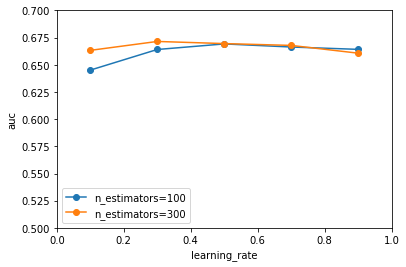

In [139]:
plt.plot(learning_rate_list, auc1, "o-", label="n_estimators=100")
plt.plot(learning_rate_list, auc2, "o-", label="n_estimators=300")
plt.axis([0,1,0.5,0.7])
plt.xlabel("learning_rate")
plt.ylabel("auc")
plt.legend()
plt.show()

# LogisticRegression
C = 0.1

penalty = l1

In [140]:
from sklearn.linear_model import LogisticRegression
C_list = [0.01,0.1,1,10,100]
auc1, auc2 = [], []
for C in C_list:
    model = LogisticRegression(C=C, penalty="l2")
    model.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc1.append(roc_auc_score(np.array(valid_y).reshape(-1), model.predict_proba(np.array(valid_x))[:,1]))
    
    model = LogisticRegression(C=C, penalty="l1")
    model.fit(np.array(train_x), np.array(train_y).reshape(-1))
    auc2.append(roc_auc_score(np.array(valid_y).reshape(-1), model.predict_proba(np.array(valid_x))[:,1]))

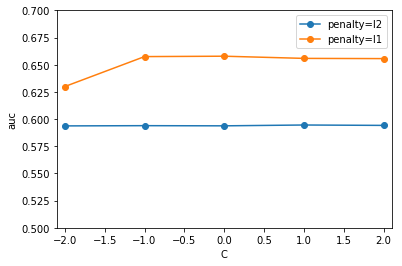

In [144]:
plt.plot(np.log10(C_list), auc1, "o-", label="penalty=l2")
plt.plot(np.log10(C_list), auc2, "o-", label="penalty=l1")
plt.axis([-2.1,2.1,0.5,0.7])
plt.xlabel("C")
plt.ylabel("auc")
plt.legend()
plt.show()

In [ ]:
LogisticRegression()